In [61]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as dt

%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from matplotlib import rcParams

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [62]:
df  = pd.read_csv('SalesData.csv', parse_dates = {'date_col' : [ "MTH", "YR"]})
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [63]:
df.head()

,date_col,CountryName,ContinentName,ProductName,UNITCOST,UNITPRICE,SALESQUANTITY,TOTALCOST,SALESAMOUNT,YRMONTH,DATE
0,2007-01-01,Australia,Asia,A. Datum Compact Digital Camera M200 Green,59.320,129.000,6,355.920,735.300,200701,01-01-2007
1,2007-01-01,Australia,Asia,A. Datum Consumer Digital Camera E100 Black,143.260,281.000,13,1719.120,3610.850,200701,01-01-2007
2,2007-01-01,Australia,Asia,Adventure Works Desk Lamp E1200 Grey,15.290,29.990,6,91.740,175.441,200701,01-01-2007
3,2007-01-01,Australia,Asia,Contoso DVD 12-Inch Player Portable M400 White,82.770,179.990,13,1076.010,2258.874,200701,01-01-2007
4,2007-01-01,Australia,Asia,Contoso DVD 48 DVD Storage Binder M50 Silver,8.270,17.990,13,107.510,223.076,200701,01-01-2007


In [64]:
df.dtypes

date_col         datetime64[ns]
CountryName              object
ContinentName            object
ProductName              object
UNITCOST                float64
UNITPRICE               float64
SALESQUANTITY             int64
TOTALCOST               float64
SALESAMOUNT             float64
YRMONTH                   int64
DATE                     object
dtype: object

In [65]:
#checking number of columns and rows
df.shape

(744613, 11)

In [66]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  11
0  /  744613


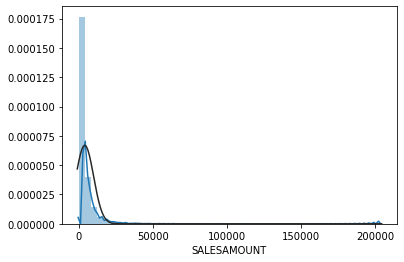

In [67]:
#seems like we dont have any column or row with null value
# lets have a look at distribution plot of SALESAMOUNT
sns.distplot(df['SALESAMOUNT'], fit=norm)

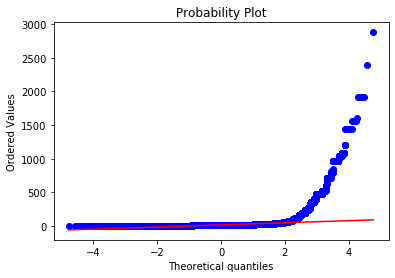

In [68]:
#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SALESQUANTITY'], plot=plt)
plt.show()

In [69]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['SALESQUANTITY'].skew()

18.047864524791805

In [70]:
#The amount of orders shipped by each country.
df.groupby('date_col').sum().sort_values('date_col', ascending = True)

,UNITCOST,UNITPRICE,SALESQUANTITY,TOTALCOST,SALESAMOUNT,YRMONTH
date_col,,,,,,
2007-01-01,2910720.670,6655317.032,299665,29955569.230,67637250.141,5262380220
2007-02-01,3227739.810,7372364.508,317733,35673007.330,81226704.545,5207614794
2007-03-01,3466561.260,7869055.762,330272,37898167.090,85539431.679,5575127934
2007-04-01,3833021.410,8737409.644,367580,42787573.790,98012321.910,5974958080
2007-05-01,3959415.560,9021919.436,392866,46379230.800,106933800.275,6064502280
2007-06-01,3753697.340,8545100.252,377959,44270542.600,102001630.642,5860414494
2007-07-01,3706144.430,8527512.886,387129,44809009.520,105091584.272,5754871811
2007-08-01,3882880.010,9047274.380,333079,40956001.010,96570512.090,5791630048
2007-09-01,3734962.190,8689311.054,329488,39572038.320,93050329.194,5659391673


In [71]:
#Summation by CountryName
df.groupby('CountryName').sum().sort_values('SALESQUANTITY',ascending = False)
# we can see that China has highest sales quantity, followed by Germanu and UK


,UNITCOST,UNITPRICE,SALESQUANTITY,TOTALCOST,SALESAMOUNT,YRMONTH
CountryName,,,,,,
China,41869069.950,97694502.968,5701983,580065687.060,1330299458.357,60376286655
Germany,21075892.740,49124241.386,2847346,291644280.480,671305227.365,33148083057
United Kingdom,13581941.290,31546549.370,1116238,120171015.890,277709182.704,19176320676
Canada,9626168.930,22339586.520,861827,93459919.290,218056206.154,13652665187
Germany,8933736.400,20711428.770,736234,80374351.590,185355462.751,12206918435
Australia,3901806.540,9148691.950,388190,39453618.020,91127716.928,5455960814
India,3912751.930,9122970.650,384473,39536323.790,90828281.417,5484467036


7


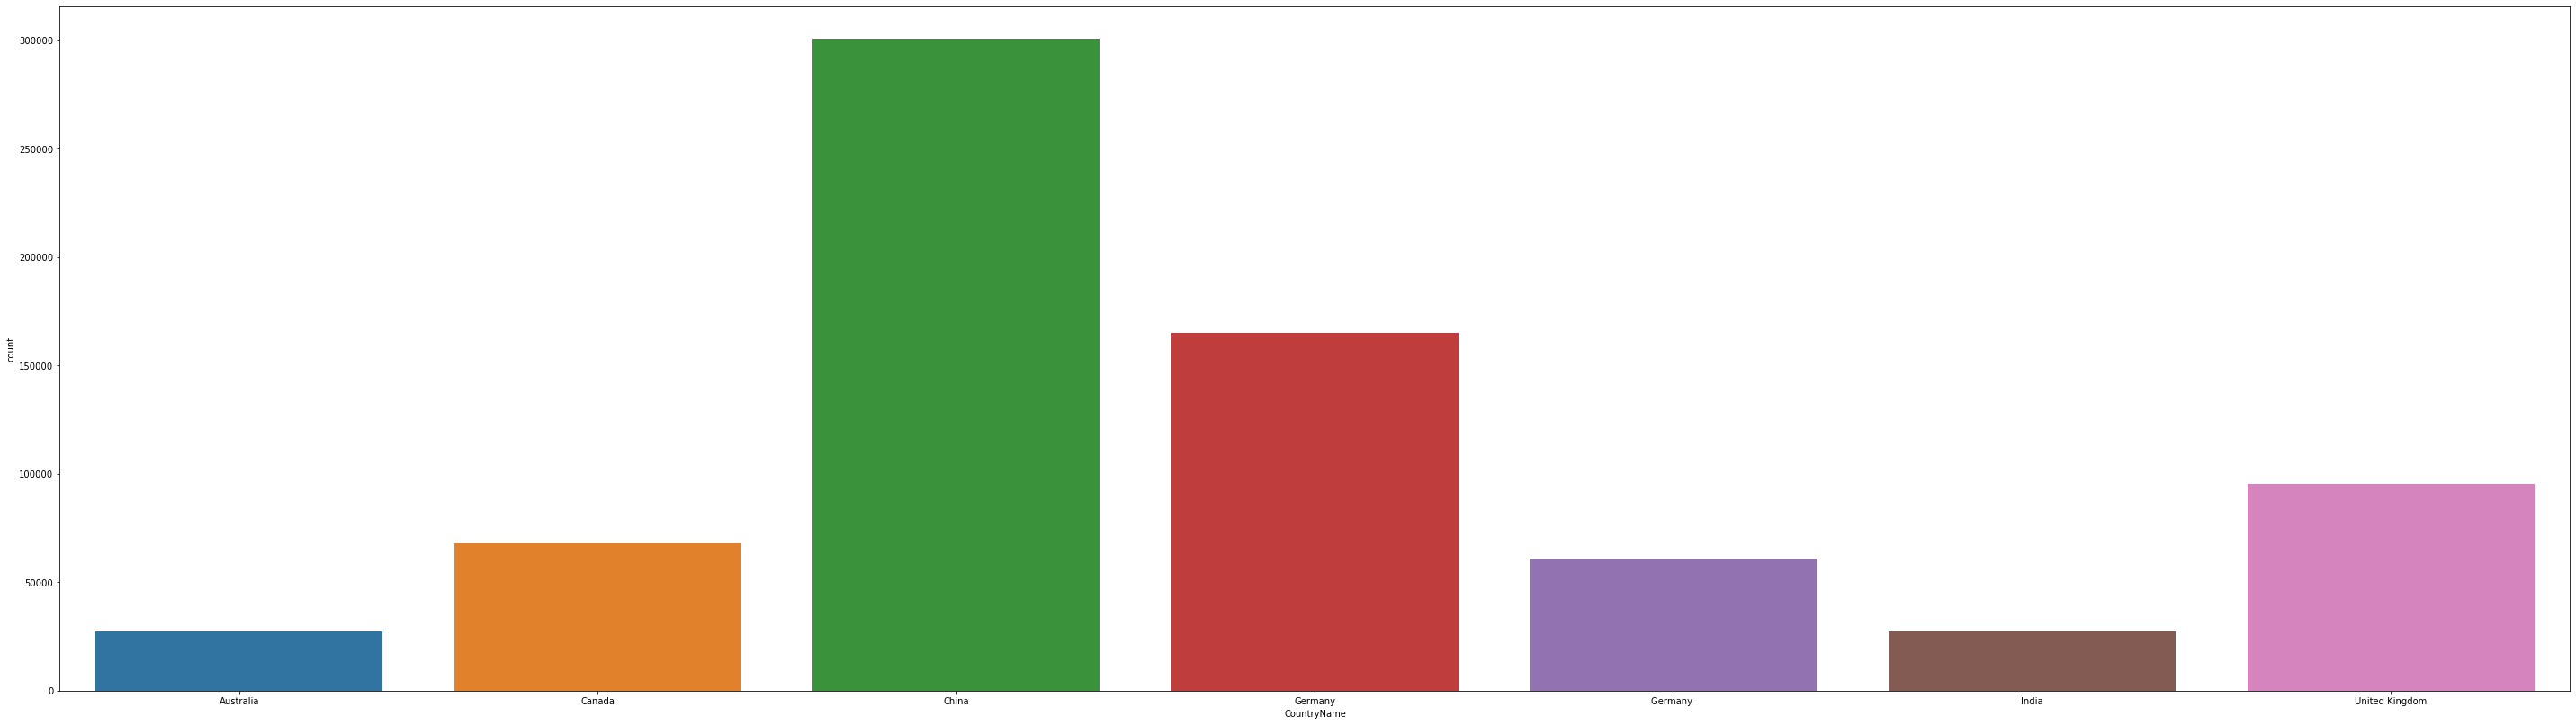

In [72]:
#Product Category.

print (len(df['CountryName'].value_counts()))

rcParams['figure.figsize'] = 50,14
sns.countplot(df['CountryName'].sort_values(ascending = True))

#We can see that number of orders is highest in China and so is the sum of sales

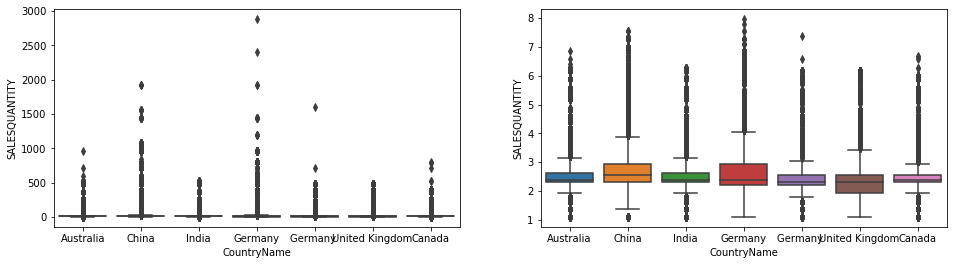

In [73]:
#Lets check the orders by CountryName.

#Checking with Boxplots
# figure size in inches
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)
#Regular Data
fig1 = sns.boxplot( df['CountryName'],df['SALESQUANTITY'], ax = axes[0])
#Data with Log Transformation
fig2 = sns.boxplot( df['CountryName'], np.log1p(df['SALESQUANTITY']),ax = axes[1])

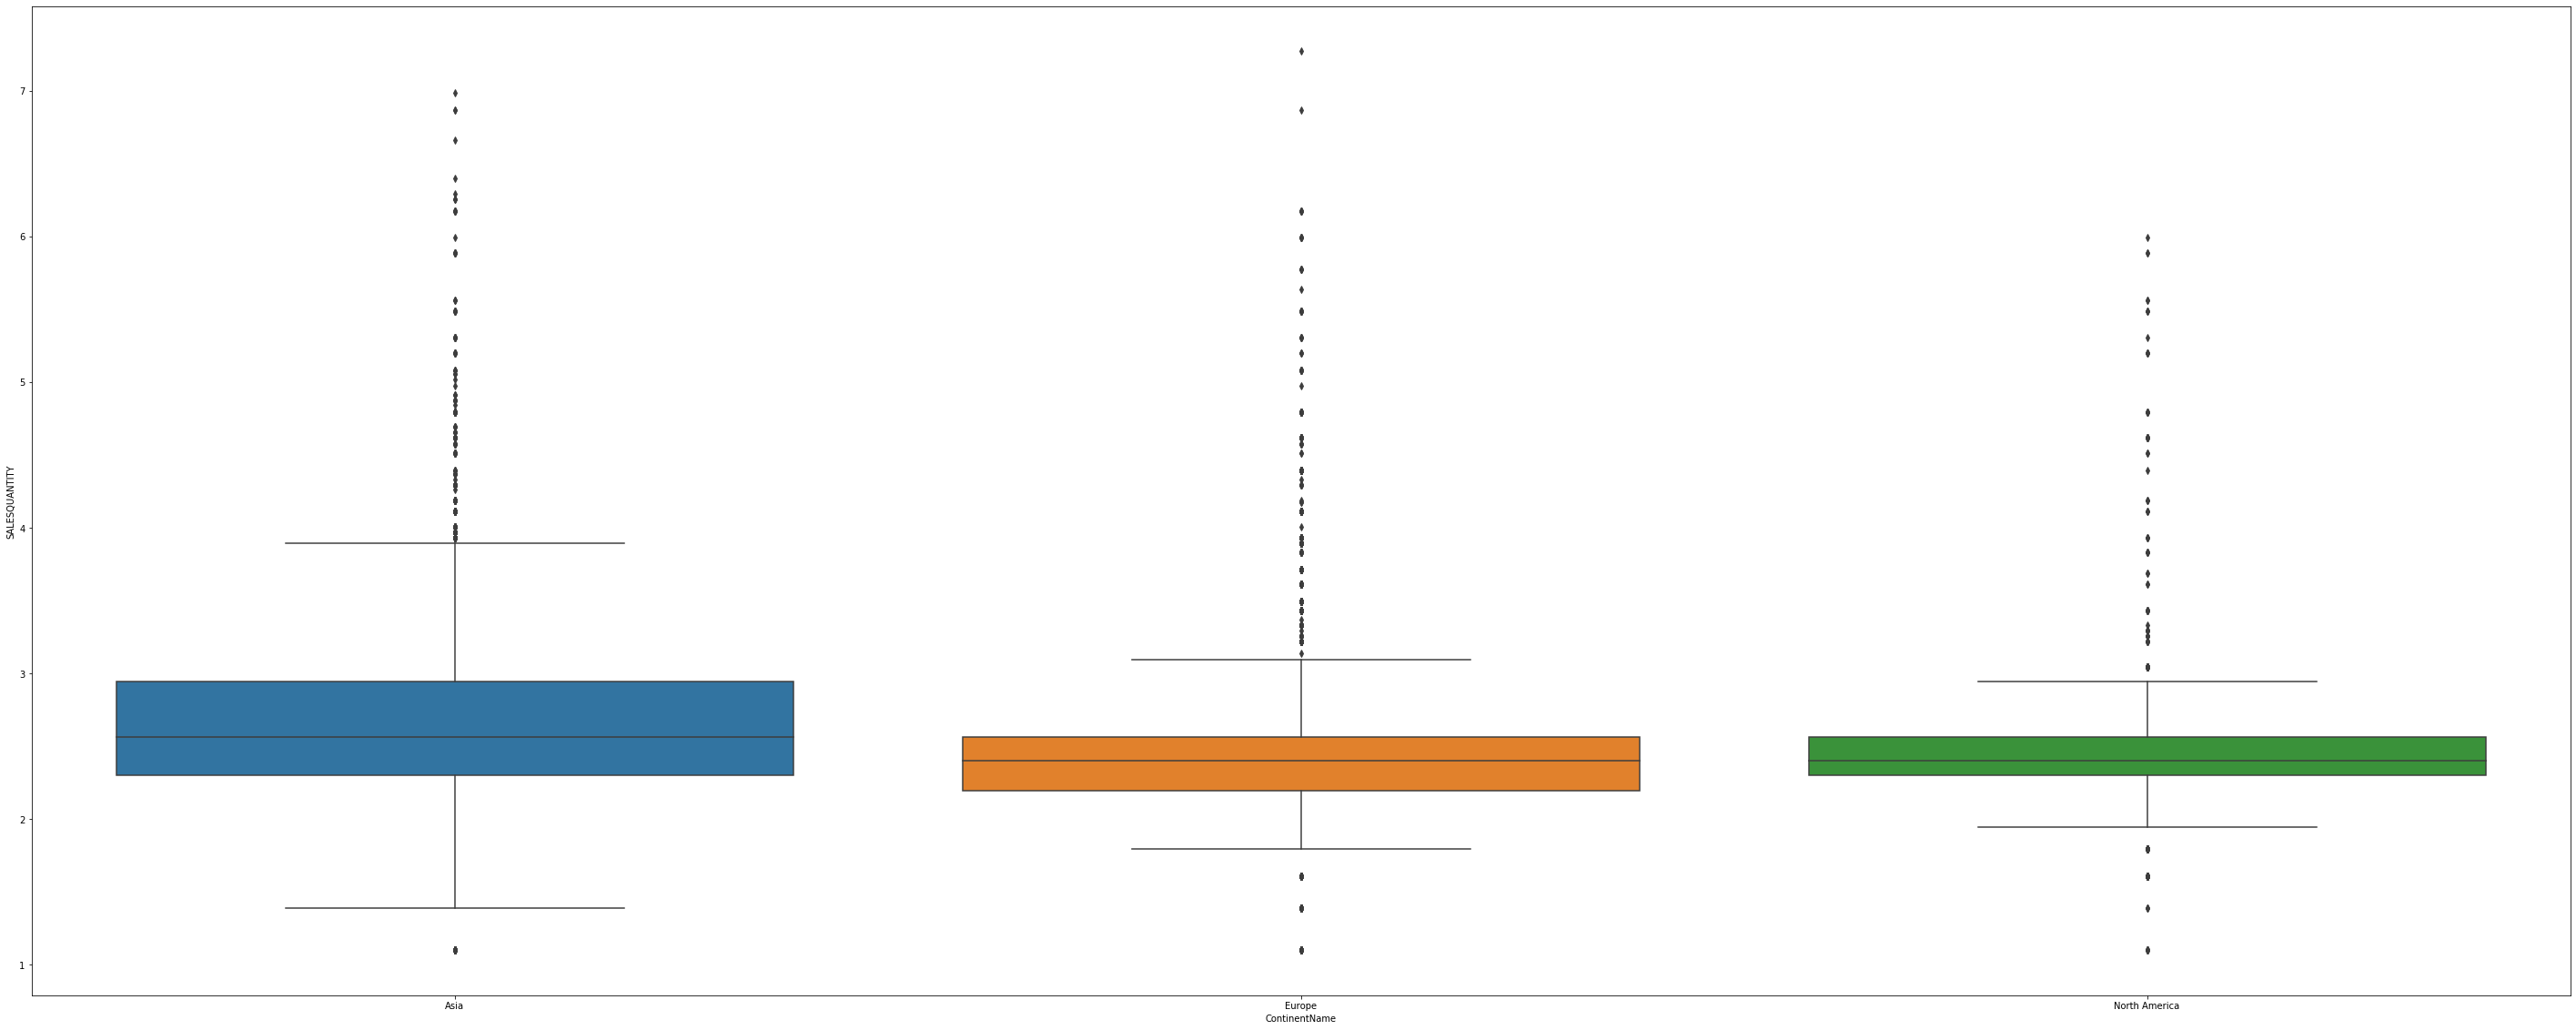

In [74]:
#Lets check the Orders by ContinentName.
rcParams['figure.figsize'] = 50,20
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig3 = sns.boxplot( df_temp['ContinentName'].sort_values(),np.log1p(df_temp['SALESQUANTITY']))
del df_temp, fig3

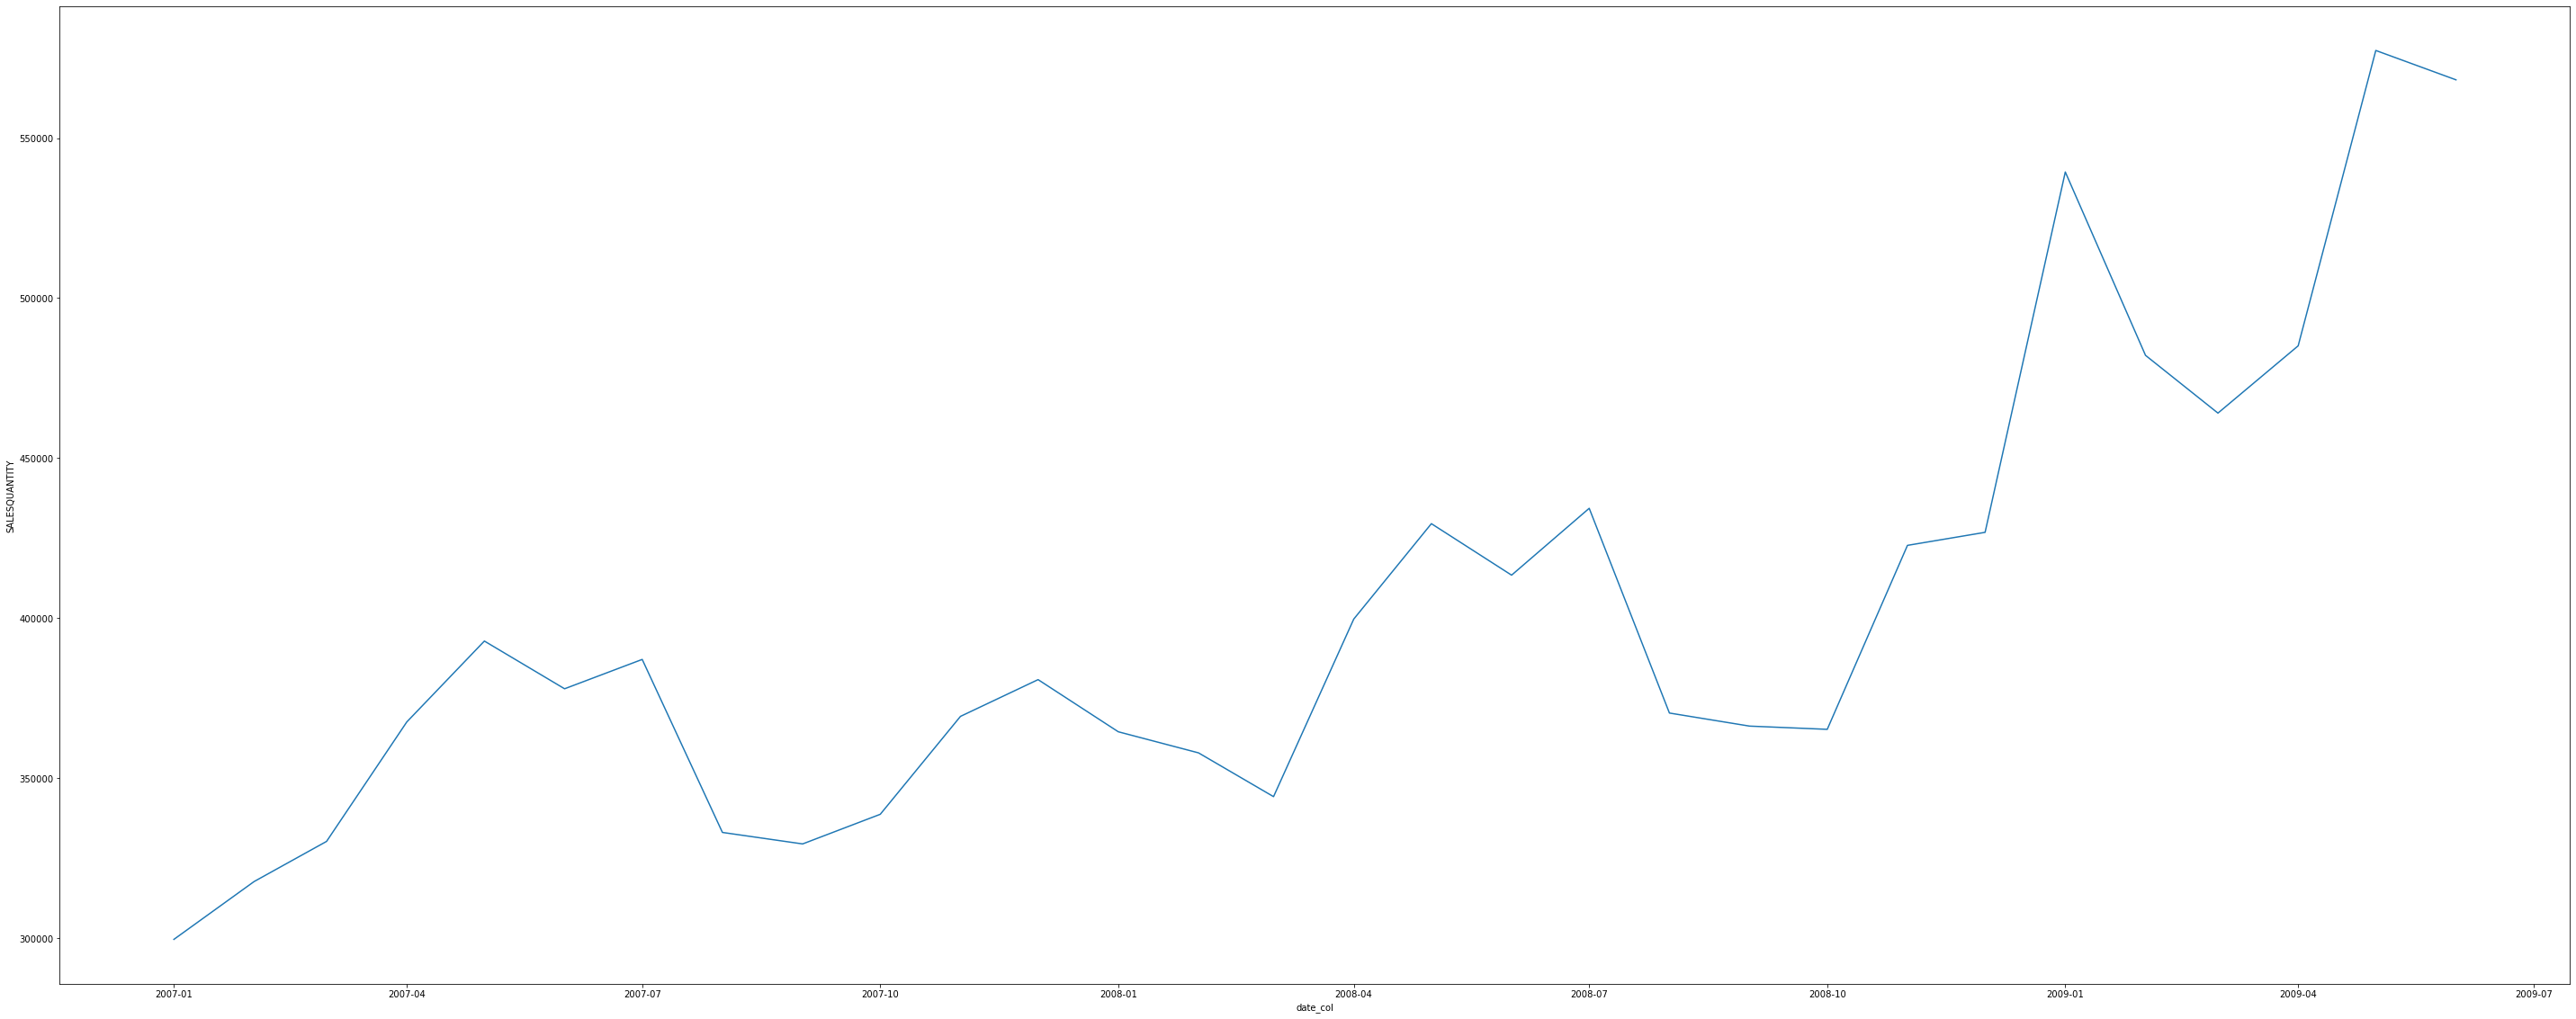

In [75]:
# Time Series Analysis
df1 = df.groupby('date_col')['SALESQUANTITY'].sum().reset_index()
#Index the date
df = df.set_index('date_col')
df.index #Lets check the index
#This gives us the total orders placed on each day and loads the data in df1 data frame.
df1
ax = sns.lineplot(x="date_col", y="SALESQUANTITY", data=df1)
ax.plot(figsize=(12,5))
plt.show()


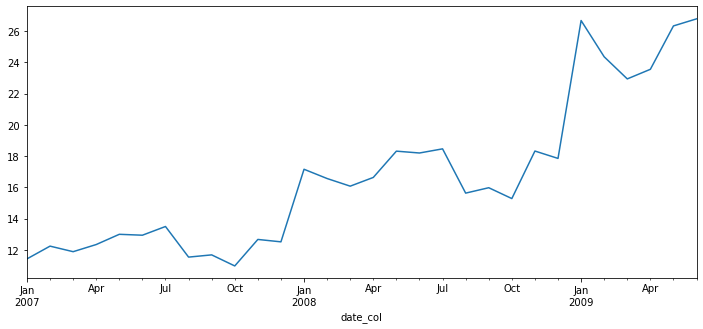

In [76]:
y = df['SALESQUANTITY'].resample('MS').mean()
y.plot(figsize=(12,5))
plt.show()

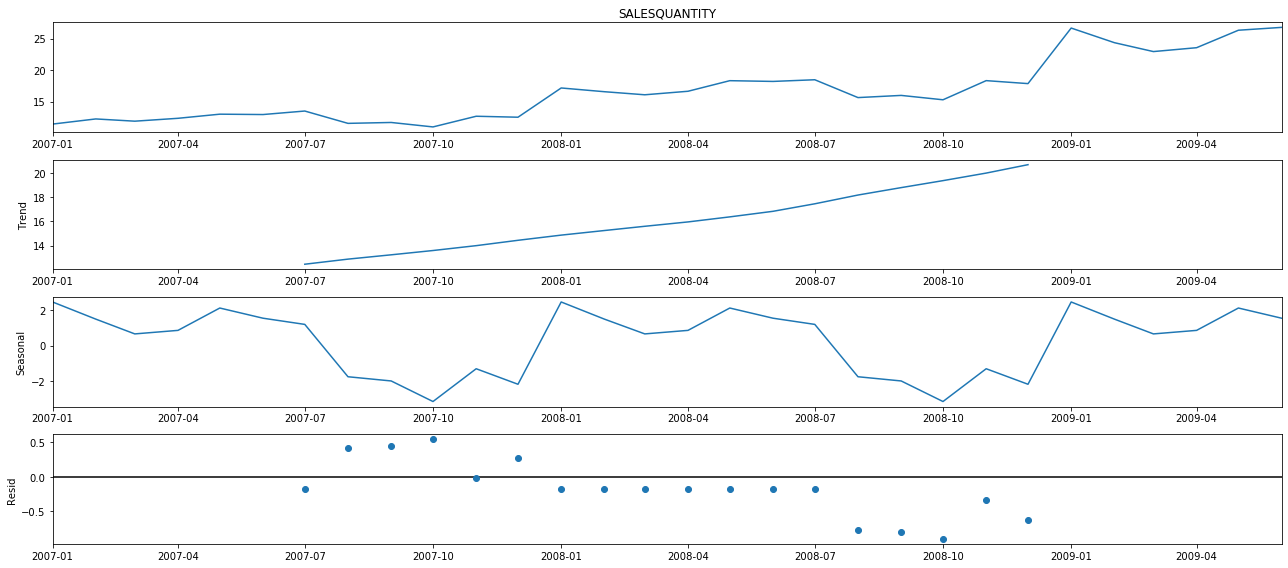

In [47]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#Takeaway: The sales are always highest for the beginning of the year and the lowest demand every year is in the
#last quarter. The observed trend shows that orders were higher during 2009 and have been increasing continiously.


In [77]:
#Grid Search

#Since ARIMA has hyper params that can be tuned, the objective here is to find the best params using Grid Search.

#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [78]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:250.59677084381013
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:149.5989572060777
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:111.76356216466255
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:34.89644494769691
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:46.923495124083644


c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:45.19791444925648
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10.370541215479205
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12.075950921645525
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:215.40549757599246
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:128.0101031973382
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:92.46958685103903
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:27.122183284069862
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:46.16098838380646


c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:46.742344293726845
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:12.433308269804183
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.89680937464163
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:127.57894997073393
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:79.13249581841194
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:55.61357489457374
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:11.25770758201343
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:40.84772814256877
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:25.910986745756578
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:10.278881592044318
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:11.885003397632603
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:125.02589915102081
SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:76.89329524856848
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:54.05797793847
SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:9.121625429471766
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:42.57493983135629
SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:32.04769928246904
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:12.2668

c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:41.327906988637935
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:11.839471558889468
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:13.8394547111823
SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:127.90202291857965
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:81.27398697834718
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:57.070780901134896
SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:9.168972004400128
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:44.2721220278234
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:34.71940777308321
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:11.512780328251907


c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:11.569997753278894
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:128.3056840761901
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:80.37498328990698
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:56.72025545046182
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:10.537611657074557
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:30.807128162546945
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:32.79338529662205
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:11.499175500184723
SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:12.25273971552847
SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:124.3816360307126
SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:77.09921481114874
SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:55.84480941947486
SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:9.608748954185126
SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:32.806657961878315
SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:31.40652921916968
SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:13.520407794438068
SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:11.25917672785344


In [79]:
#Fit the model with the best params.
#ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.89680937464163


#The above output suggests that ARIMA(0, 0, 1)x(1, 1, 1, 12) yields the lowest AIC value: 8.89
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0493      0.553      0.089      0.929      -1.034       1.133
ar.S.L12       1.5884      0.070     22.594      0.000       1.451       1.726
ma.S.L12       0.7719      0.006    135.392      0.000       0.761       0.783
sigma2         0.0459      0.128      0.358      0.721      -0.206       0.298


c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3048: UserWarning: Early subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3053: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\users\satyam.anand\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\users\satyam.anand\appdata\local\programs\pyth

ValueError: operands could not be broadcast together with shapes (9,) (2,) (9,) 

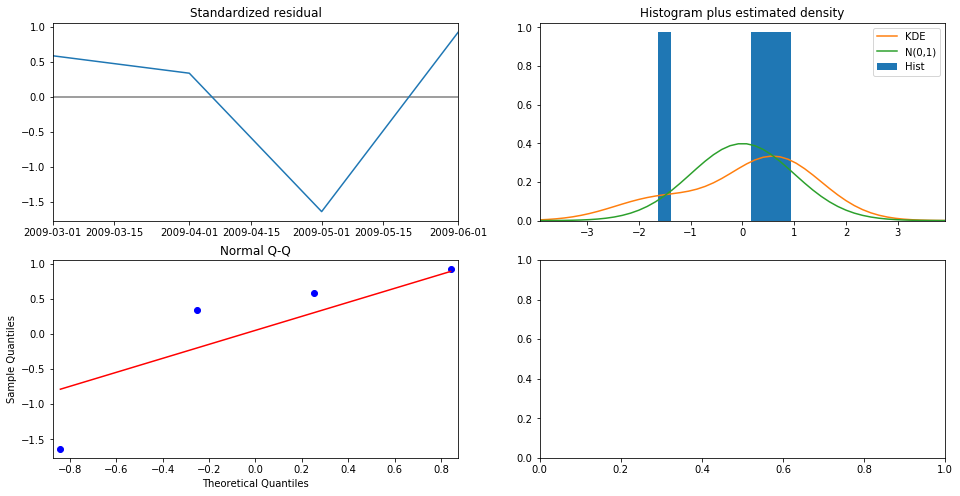

In [80]:
#Interpreting the table:

#coeff: Shows weight/impotance how each feature impacts the time series. Pvalue: Shows the significance of each feature weight. Can test hypothesis using this. If p value is <.05 then they are statitically significant.

#Refresher on null hyp and pvalues. By default we take the null hyp as 'there is no relationship bw them' If p value < .05 (significance level) then you reject the Null Hypthesis If p value > .05 , then you fail to reject the Null Hypothesis.

#So, if the p-value is < .05 then there is a relationship between the response and predictor. Hence, significant.


#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Cross
#Hence, we cannot perform seasonal ARIMA on this data.